# Dataset Statistics for Compound Gene Sentences

This notebook is designed to show statistics on the data extracted from pubmed. The following cells below here are needed to set up the environment.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter
from itertools import product
import os
import pickle
import sys

sys.path.append(os.path.abspath('../../../modules'))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

sns.set(rc={'figure.figsize':(12,6), "font.size":17})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [4]:
from snorkel.models import candidate_subclass, Candidate
CompoundGene = candidate_subclass('CompoundGene', ['Compound', 'Gene'])

In [5]:
from utils.notebook_utils.dataframe_helper import write_candidates_to_excel, make_sentence_df

## Load and Merge DataFrames

In [9]:
edge_level_df = pd.read_csv("input/compound_binds_gene.tsv.xz", sep="\t")
edge_level_df.head(2)

,entrez_gene_id,gene_symbol,drugbank_id,name,sources,hetionet,n_sentences,has_sentence,partition_rank,split
0,1,A1BG,DB00117,L-Histidine,NaN,0,1,1,0.37753,6
1,1,A1BG,DB00143,Glutathione,NaN,0,1,1,0.30352,6


In [11]:
sql = '''
select cand_id as candidate_id, drugbank_id, entrez_gene_id, sentence_id, text, array_length(words, 1) as sen_length from (
    select cand_id, "Gene_cid" as entrez_gene_id, "Compound_cid" as drugbank_id, sentence_id from 
        (
            select compound_gene.id as "cand_id", compound_gene."Compound_id",
            compound_gene."Gene_cid", compound_gene."Compound_cid", candidate.split from compound_gene 
            inner join candidate on compound_gene.id=candidate.id 
        ) as candidate_splits inner join span on candidate_splits."Compound_id"=span.id
    ) as candidate_sen inner join sentence on candidate_sen.sentence_id=sentence.id
'''
candidate_sentence_df = pd.read_sql(sql, database_str).astype({"entrez_gene_id": int})
candidate_sentence_df.head(2)

,candidate_id,drugbank_id,entrez_gene_id,sentence_id,text,sen_length
0,60759,DB04398,11181,50374,"Urinary excretion of lactate dehydrogenase, hy...",47
1,60755,DB04398,10724,50374,"Urinary excretion of lactate dehydrogenase, hy...",47


In [14]:
total_candidates_df= (
    edge_level_df
    .merge(candidate_sentence_df, on=["drugbank_id", "entrez_gene_id"])
)
total_candidates_df.head(2)

,entrez_gene_id,gene_symbol,drugbank_id,name,sources,hetionet,n_sentences,has_sentence,partition_rank,split,candidate_id,sentence_id,text,sen_length
0,1,A1BG,DB00117,L-Histidine,NaN,0,1,1,0.37753,6,33517095,94389805,"Thus, as the assessment of protein glycosylati...",92
1,1,A1BG,DB00143,Glutathione,NaN,0,1,1,0.30352,6,28913100,83523801,Similar observations were made in T98 glioma c...,33


In [18]:
dev_candidates = (
    session
    .query(CompoundGene)
    .filter(
        CompoundGene.id.in_(
            total_candidates_df
            .query("split==7")
            .sample(10000, random_state=100)
            .candidate_id
            .tolist()
        )
    )
    .all()
)
dev_df = make_sentence_df(dev_candidates)
dev_df.head(2)

,candidate_id,compound,gene,drugbank_id,entrez_gene_id,sentence
0,50920,aspartic acid,angiotensin I,DB03089,183,"at high enzyme concentration , the enzyme cata..."
1,51923,netilmicin,Gmr),DB00955,1438,an apparently homogeneous strain of staphyloco...


In [19]:
test_candidates = (
    session
    .query(CompoundGene)
    .filter(
        CompoundGene.id.in_(
            total_candidates_df
            .query("split==8")
            .sample(10000, random_state=100)
            .candidate_id
            .tolist()
        )
    )
    .all()
)
test_df = make_sentence_df(test_candidates)
test_df.head(2)

,candidate_id,compound,gene,drugbank_id,entrez_gene_id,sentence
0,50508,DHT,TeBG,DB07447,6462,"at a 10-fold molar excess , using both baboon ..."
1,51551,lactate,insulin-treated,DB04398,3630,"however , the mean value of blood ~~[[1 lactat..."


In [20]:
#write_candidates_to_excel(dev_df, "../data/sentences/sentence_labels_dev.xlsx")
#write_candidates_to_excel(test_df, "../data/sentences/sentence_labels_test.xlsx")

## Distribution of Sentence Length

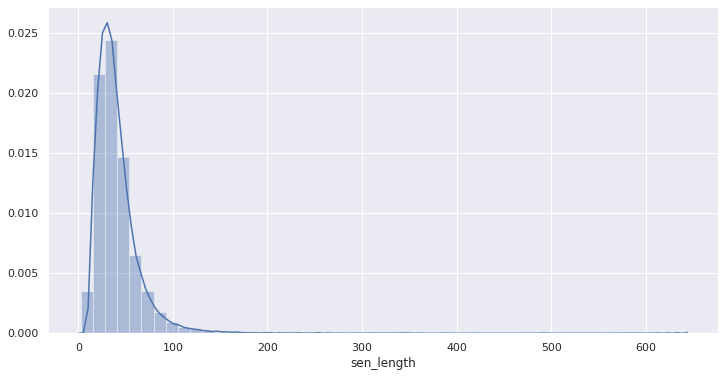

In [21]:
sns.distplot(total_candidates_df["sen_length"], rug=False)

In [22]:
total_candidates_df["sen_length"].describe().astype(int)

count    3023147
mean          40
std           26
min            3
25%           26
50%           36
75%           49
max          641
Name: sen_length, dtype: int64

Something seems fishy about this distribution. The number of words (tokens) for a given sentence is in the thousands range. Intuitively, that doesn't make sense, since the average number of words for a given sentence is 42. Possible reason for this abnormality is a parsing error. Lets take a look at this 834 word sentence.

In [23]:
total_candidates_df.query("sen_length==641").iloc[0]["text"]

'neurintsurg;6/Suppl_1/A4-a/T1T1T1 Abstract O-007 Table 1 Change in PRU values after first clopidogrel dose adjustment Clopidogrel dose adjustment (DA) Number of patients Mean Pre-DA PRU Mean Post-DA PRU Mean PRU Change Patients within target 60-240 PRU range after DA Hypo-Responders, 75 mg daily to 150mg daily 7 264 182 -82 71% Hyper-Responders 33 21 69 +48 46% 75 mg daily to 75 mg every-other-day: 17 30 61 +31 35% 75 mg daily to 75 mg every-third-day: 13 13 71 +58 54% 75 mg daily to 75 mg every-Monday-and-Friday: 3 5 104 +99 67% neurintsurg;6/Suppl_1/A4-a/T2T2T2 Abstract O-007 Table 2 Change in PRU values after subsequent clopidogrel dose adjustments Clopidogrel dose adjustment (DA) Number of patients Mean days after clopidogrel initiation Mean days after procedure Mean PRU pre-DA Mean PRU post-DA Mean PRU change Patients within target 60-240 PRU range after DA Second DA: 24 40 25 29 92 +63 71% 150mg daily to 75mg daily (n = 1) or 75mg every-other-day (n = 1) 2 43 106 +63 100% 75 mg 

The above sentence shows that a long list of drugs that a issue will cover. This isn't helpful in our case, because we want to look at sentences that contain compounds and diseases; therefore, we should remove sentences of this nature by defining a cutoff score of 83 or less words.

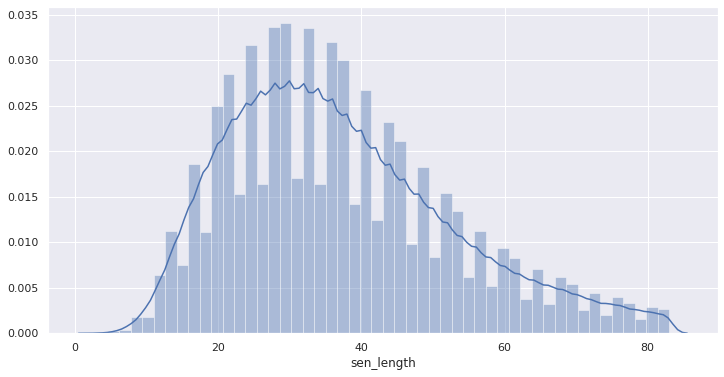

In [24]:
sns.distplot(total_candidates_df.query("sen_length < 83+1")["sen_length"], rug=False)

In [25]:
total_candidates_df.query("sen_length < 83+1")["sen_length"].describe().astype(int)

count    2883708
mean          37
std           15
min            3
25%           25
50%           35
75%           46
max           83
Name: sen_length, dtype: int64

This distribution looks a bit more reasonable compared to the above distribution. After filtering out the outliers, we still have a pleathora of sentences on the order of 2.2 million.

In [27]:
total_candidates_df.to_csv("output/all_cbg_candidates.tsv.xz", sep="\t", index=False, compression="xz")

In conclusion, the optimal cutoff point in this case would be: **84** tokens/words or smaller depending on algorithm performance. Another important lesson is to analyze one's dataset before undergoing the journey of training a deep learning model. Sentence length is an important factor, when it comes to filtering out the dataset. If ignored, a significant amount of problems will arise. For example, when training a long short term memory network (LSTM), sequence length dictates how many steps the LSTM needs to traverse in order to ultimately calculate the probability of a sentence mentioning a relationship. If the LSTM were to be fed a sentence that contains 834 words, then the network has 834 steps to parse through. This takes a significant amount of time (~20 hours+). Plus during backpropogation, the gradient will become very small that the network cannot learn anything useful ([Backpropogation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time)). 